## Implementing the Decison-tree classiffier over the Amazon-fine food reviews dataset

In [2]:
#Importing all the relevant libraries

%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from prettytable import PrettyTable
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE


<h3>Connecting to the pre-processed SQLite Table.</h3>

In [4]:
#Connecting to the SQL table
con = sqlite3.connect('final.sqlite')

#Reading data from the database
                                                                        
Data = pd.read_sql_query("""
SELECT *
FROM Reviews """,con)
Data.shape

# Drop index column
Data.drop(columns=['index'],inplace=True)


<h3>Processing the data for the further use.</h3>

In [5]:
#SETTING THE TIME COLUMN TO STANDARD DATE-TIME

Data["Time"]=pd.to_datetime(Data.Time)
Data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1970-01-01 00:00:01.194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1970-01-01 00:00:01.191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1970-01-01 00:00:01.076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1970-01-01 00:00:01.018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [6]:
#Setting Time column as index of the dataframe 
Data.set_index("Time",inplace=True)

#Sampling the above data

Sampled_data=Data.sample(n=150000,replace='False')
Sorted=Sampled_data.sort_index()
Sorted.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,CleanedText
Time,,,,,,,,,,
1970-01-01 00:00:00.939340800,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1970-01-01 00:00:00.940809600,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
1970-01-01 00:00:00.947376000,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
1970-01-01 00:00:00.951523200,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
1970-01-01 00:00:00.959990400,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,positive,Research,I'm getting crazy.<p>Is it really impossible t...,get crazi realli imposs today find french vhs ...


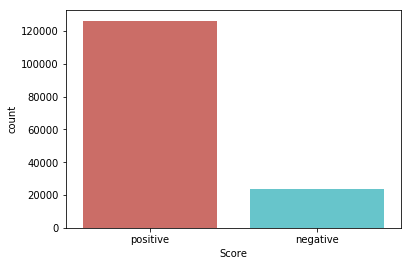

<Figure size 432x288 with 0 Axes>

In [7]:
polarity=Sorted["Score"]
sns.countplot(x="Score",data=Sorted,palette="hls")
plt.show()
plt.savefig("count_plot")


<h3>Splitting the data into 80:20 partitions sets</h3>

In [8]:
def data_split(x,y):
    #Splitting the model into 70:30 split of Training and Cross_validate split
    X_1, X_test, y_1, y_test = train_test_split(x, y, test_size=0.3,shuffle=False,random_state=None)

# split the train data set into cross validation train and cross validation test
    X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3,shuffle=False,random_state=None)
    
    return X_tr,y_tr,X_cv,y_cv,X_test,y_test

<h3>Preparing the data for further use</h3>

In [9]:
X=Sorted
Y=polarity

X_tr,y_tr,X_cv,y_cv,X_test,y_test=data_split(X,Y)

print("The shape of x_train is:",X_tr.shape)
print("the shape of y_train is:",y_tr.shape)
print("the shape of x_test is:",X_test.shape)
print("the shape of y_test is:",y_test.shape)

The shape of x_train is: (73500, 10)
the shape of y_train is: (73500,)
the shape of x_test is: (45000, 10)
the shape of y_test is: (45000,)


<h3>Utility functions for training & testing the data</h3>

In [21]:
def train(X_tr, y_tr,X_cv,y_cv):
    
    clf = DecisionTreeClassifier(random_state=0,max_depth=None,class_weight="balanced")
    Model = clf.fit(X_tr, y_tr)

    print("\nThe model score on train set is= ", Model.score(X_tr,y_tr))

    Y_pred=Model.predict(X_cv)

    accuracy = accuracy_score(y_cv, Y_pred, normalize=True) * float(100)

    print('\nThe accuracy of Decision tree over cross_val set is =  %d%% ' % ( accuracy))
    return Y_pred,accuracy




def tuned_test(X_tr, y_tr,X_test,y_test,d):
    
    Best_clf= DecisionTreeClassifier(random_state=0,max_depth=d,class_weight="balanced")

    Best_Model = Best_clf.fit(X_tr, y_tr)

    print("\nThe model score on train set is= ", Best_Model.score(X_tr,y_tr))

    Y_pred=Best_Model.predict(X_test)
    
    best_accuracy = accuracy_score(y_test, Y_pred, normalize=True) * float(100)

    print('\nThe accuracy of Decision tree over test set is =  %d%% ' % ( best_accuracy))
    return Y_pred,best_accuracy


def cv_results(X_cv, y_cv):
    cv_erro_array1 = []
    depth = [x for x in range(2, 10)]
    
    for d in depth:
        print("--------------------------------------------------------------------------------------------------------")
        print("for depth =", d)
        Clf = DecisionTreeClassifier(random_state=0,max_depth=(d),class_weight="balanced")
        Scores = cross_val_score(Clf, X_cv, y_cv, cv=10,scoring='accuracy',n_jobs=-1)
        cv_erro_array1.append(Scores.mean())
    
        mse=[1- x for x in cv_erro_array1]
        # determining best alpha
        #Best_alpha = alpha[mse.index(min(mse))]
        print("\nthe misclassification error for each depth value is : ", np.round(mse,3))
        #print("\nthe 10-fold CV_accuracy for each alpha is :",Scores)
    
    #plt.subplot(1,2,1)
    
    fig, ax = plt.subplots()
    ax.plot(depth,mse,c='g')
    for i, txt in enumerate(np.round(mse,3)):
        ax.annotate((depth[i],str(txt)), (depth[i],mse[i]))
    plt.grid()
    plt.title("Cross Validation Error for each depth value")
    plt.xlabel("Depth d's")
    plt.ylabel("Error measure")
    plt.show()

    Best_depth = np.round(depth[mse.index(min(mse))])
    print('\nThe optimal number of depth value is %d.' % Best_depth)





<h3>Utility function for plotting the confusion matrix.</h3>

In [11]:
from sklearn.metrics import confusion_matrix
def Confusion_metric(y_test,y_pred,acc):
    print(metrics.confusion_matrix(y_test,y_pred))
    confusion=metrics.confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(confusion, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Predicted label');
    plt.xlabel('Actual label');
    all_sample_title = 'Accuracy Score: {0}'.format( acc)
    plt.title(all_sample_title, size = 15);
    plt.show()

#Storing the values of the confusion matrix
    TN=confusion[0,0]
    FP=confusion[0,1]
    FN=confusion[1,0]
    TP=confusion[1,1]

# use float to perform true division, not integer division
    Class_acc=((TP + TN) / float(TP + TN + FP + FN))*100

#Code for classification error

    classification_error = ((FP + FN) / float(TP + TN + FP + FN))*100
    

#Code for finding the TPR,FPR,TNR,FNR

    TPR = (TP / float(FN + TP))*100

    FNR = (FN / float(FN + TP))*100

    TNR=(TN / float(TN + FP))*100

    FPR=(FP / float(TN + FP))*100
    
#Code for finding the Precision,Recall & F1_score    
   
    precision = (TP/float(TP+FP))*100
    
    recall= (TP / float(FN + TP))*100
    
    F1_s= ((float(precision*recall)/float(precision+recall))*2)
    
    print()
    
    ptable=PrettyTable()
    ptable.title="The performance metrics of the above model are as follows: "
    ptable.field_names=["Metrics","Scores"]
    ptable.add_row(["Classification_accuracy",Class_acc])
    ptable.add_row(["Classification_error",classification_error])
    ptable.add_row(["True positive",TP])
    ptable.add_row(["False positive",FP])
    ptable.add_row(["True negative",TN])
    ptable.add_row(["False negative",FN])
    ptable.add_row(["True positive rate",TPR])
    ptable.add_row(["False negative rate",FNR])
    ptable.add_row(["True negative rate",TNR])
    ptable.add_row(["False positive rate",FPR])
    ptable.add_row(["Precision value",precision])
    ptable.add_row(["Recall value",recall])
    ptable.add_row(["f1_score value",F1_s])
    
    print(ptable)
    

In [51]:

def conclusion_table():
    print()
    ptable=PrettyTable()
    ptable.title="The comparisons of all the vectorizers are as follows: "
    ptable.field_names=["Vectorizer","Algorithm","Scores","Status"]
    ptable.add_row(["Bag-Of-Words","Decision-Tree-Classiffier",accuracy,"Overfitt"])
    ptable.add_row(["Tf-IDF","Decision-Tree-Classiffier",accur ,"Overfitt"])
    ptable.add_row(["Average-word2vec","Decision-Tree-Classiffier",accura ,"Overfitt"])
    ptable.add_row(["TF-IDF-Weighted-word2vec","Decision-Tree-Classiffier",tfaccura ,"Overfitt"])
      
    print(ptable)
    
    

<h3>Utility function for vectorizing the data</h3>

In [12]:
#Function for vectorizing the train data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler(with_mean=False)


def vec_train(vect,X_tr):
    import warnings
    warnings.filterwarnings("ignore")

    count_vect = vect #in scikit-learn
    BOW = count_vect.fit_transform(X_tr.values)

#Standardizing the vectorized data
    standardized_data = scaler.fit_transform(BOW)
    standardized_data.shape
    return count_vect,standardized_data


#Function for vectorizing the CV data

def vec_cv(count,X_cv):
    cv=count.transform(X_cv.values)
    cv.get_shape()

    std_cv=scaler.transform(cv)
    std_cv.shape
    return std_cv


#Function for vectorizing the test data

def vec_test(count,X_test):
    test=count.transform(X_test.values)
    test.get_shape()

    std_data=scaler.transform(test)
    std_data.shape
    return std_data

#Funtion for printing the total number of top features
def top_tfidf_feats(name,row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', name]
    return df

#Function for displaying top frequent 50 tokens distributions 
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
def display_token(Vect,data):

    vectorizer = Vect
    docs       = vectorizer.fit_transform(data)
    features   = vectorizer.get_feature_names()
    
    visualizer = FreqDistVisualizer(features=features)
    visualizer.fit(docs)
    visualizer.poof()







<h3>Implementing the Bag-of words vectorizer</h3>

In [13]:
#Initializing the count vectorizer 
Count_vect=CountVectorizer()

#vectorizing the X_train set
count,x_tr=vec_train(Count_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",x_tr.shape)

#Vectgorizing the X_crossvalidation set
x_cv=vec_cv(count,X_cv["CleanedText"])
print("The shape of the X_cv is: ",x_cv.shape)


#Vectorizing the X_test set
x_test=vec_test(count,X_test["CleanedText"])
print("The shape of the X_test is: ",x_test.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the Bow score are as follows")
features = Count_vect.get_feature_names()
len(features)


top_Bow = top_tfidf_feats("bow",x_tr[1,:].toarray()[0],features,25)
top_Bow




The shape of the X_train is:  (73500, 29756)
The shape of the X_cv is:  (31500, 29756)
The shape of the X_test is:  (45000, 29756)

Top 25 feaures acording to the Bow score are as follows


,feature,bow
0,televis,67.784587
1,preschool,52.183137
2,song,45.833249
3,thirti,35.308593
4,teach,34.166100
5,seri,32.651272
6,student,20.112397
7,book,18.799685
8,sister,11.680474
9,school,11.466476


### <h3>Displaying the top frequency distribution of the top 50 tokens

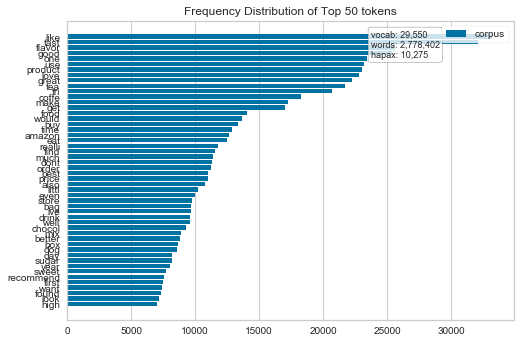

In [13]:
display_token(Count_vect,X_tr["CleanedText"])

### Training the Decision tree classifier model over the cross-validation set using default values

In [14]:
%%time

pred,acc=train(x_tr,y_tr,x_cv,y_cv)


The model score on train set is=  1.0

The accuracy of Decision tree over cross_val set is =  81% 
Wall time: 35.1 s


### Confusion matrix of the model is as follows 

[[ 2956  2507]
 [ 3269 22768]]


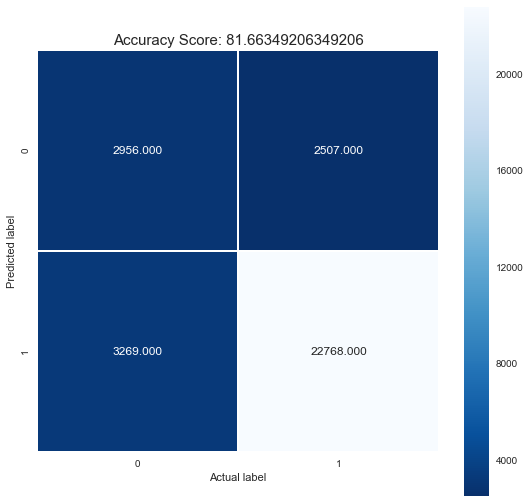


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     81.66349206349206     |
|       Classification_error      |     18.336507936507935    |
|          True positive          |           22768           |
|          False positive         |            2507           |
|          True negative          |            2956           |
|          False negative         |            3269           |
|        True positive rate       |     87.44479010638706     |
|       False negative rate       |     12.555209893612934    |
|        True negative rate       |     54.10946366465312     |
|       False positive rate       |     45.89053633534688     |
|         Precision value         |    

In [46]:
Confusion_metric(y_cv,pred,acc)

## Observations
<ul>
   <li>The train accuracy of the above model is 81.422% but is quite misleading which can be observed by analyzing the performance metrics of the confusion matrix.</li>
   <li>The False positive rate and the false negative rate is quite high which is not good for an classification model.</li>
   <li>The True negative rate is quite low which is very bad as the negative reviews are not properly classified and the model is facing a bias problem which can be improved after tuning the hyperparameters.</li>
    

### Tuning the hyperparameters by performing 10k-fold Cross validation technique

--------------------------------------------------------------------------------------------------------
for depth = 2

the misclassification error for each depth value is :  [0.544]
--------------------------------------------------------------------------------------------------------
for depth = 3

the misclassification error for each depth value is :  [0.544 0.426]
--------------------------------------------------------------------------------------------------------
for depth = 4

the misclassification error for each depth value is :  [0.544 0.426 0.399]
--------------------------------------------------------------------------------------------------------
for depth = 5

the misclassification error for each depth value is :  [0.544 0.426 0.399 0.4  ]
--------------------------------------------------------------------------------------------------------
for depth = 6

the misclassification error for each depth value is :  [0.544 0.426 0.399 0.4   0.346]
-------------------------

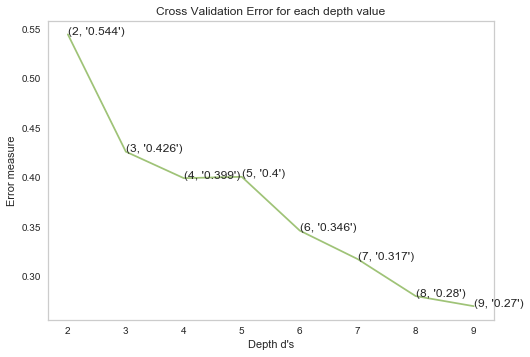


The optimal number of depth value is 9.


In [16]:
cv_results(x_tr,y_tr)

### Testing the model with the optimal depth value over the Test set

In [47]:
y_pred,accuracy=tuned_test(x_tr,y_tr,x_test,y_test,d=9)


The model score on train set is=  0.7459319727891156

The accuracy of Decision tree over test set is =  73% 


### Confusion matrix of the above model is as follows

[[ 5794  2149]
 [ 9813 27244]]


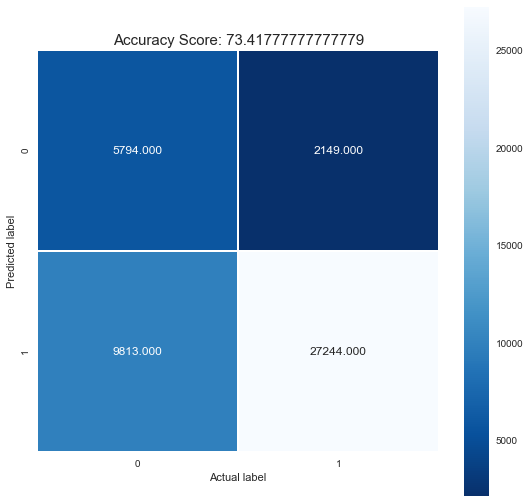


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     73.41777777777779     |
|       Classification_error      |     26.582222222222224    |
|          True positive          |           27244           |
|          False positive         |            2149           |
|          True negative          |            5794           |
|          False negative         |            9813           |
|        True positive rate       |     73.51917316566372     |
|       False negative rate       |     26.48082683433629     |
|        True negative rate       |     72.94473120987033     |
|       False positive rate       |     27.055268790129674    |
|         Precision value         |    

In [48]:
Confusion_metric(y_test,y_pred,accuracy)

## Observations
<ul>
    <li>The test accuracy with optimal depth is 73.41% which is quite low for a classification model.</li>
    <li>This drop in accuracy is due to increase in the false negative rates which is hampering the model's performance.</li>
    <li>But still the model is good and stable because of high True positive and negative rates as compared to the default model.</li>
    <li>The precision and the recall values are good but the recall value is very low which is quite alarming.</li>
    <li>Since descion trees tends to overfitt as the depth increases so this might be reason for low accuracy.</li>
    

## Implementing the TF-idf Vectorizeration technique

In [18]:
#Initializing the count vectorizer 
TF_vect=TfidfVectorizer(ngram_range=(1,2))

#vectorizing the X_train set
TF_count,X_tra=vec_train(TF_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",X_tra.shape)


#Vectgorizing the X_crossvalidation set
X_cv=vec_cv(TF_count,X_cv["CleanedText"])
print("The shape of the X_cv is: ",X_cv.shape)


#Vectorizing the X_test set
X_tes=vec_test(TF_count,X_test["CleanedText"])
print("The shape of the X_test is: ",X_tes.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the Bow score are as follows")
Features = TF_vect.get_feature_names()
len(Features)


top_tfidf = top_tfidf_feats("tfidf",X_tra[1,:].toarray()[0],Features,25)
top_tfidf




The shape of the X_train is:  (73500, 875598)
The shape of the X_cv is:  (31500, 875598)
The shape of the X_test is:  (45000, 875598)

Top 25 feaures acording to the Bow score are as follows


,feature,tfidf
0,book children,271.110679
1,day thirti,271.110679
2,song student,271.110679
3,children tradit,271.110679
4,air televis,271.110679
5,student teach,271.110679
6,child sister,271.110679
7,sister later,271.110679
8,thirti someth,271.110679
9,tradit live,271.110679


### Displaying the frequency of the top 50 Tf-idf vectorized tokens

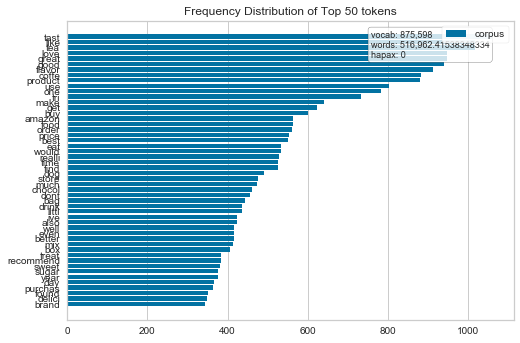

In [19]:
display_token(TF_vect,X_tr["CleanedText"])

### Training the above model over the cross-validated data

In [21]:
%%time

Pred,Acc=train(X_tra,y_tr,X_cv,y_cv)


The model score on train set is=  1.0

The accuracy of Decision tree over cross_val set is =  82% 
Wall time: 2min 41s


### Confusion matrix of the above model is as follows

[[ 2579  2806]
 [ 2777 23338]]


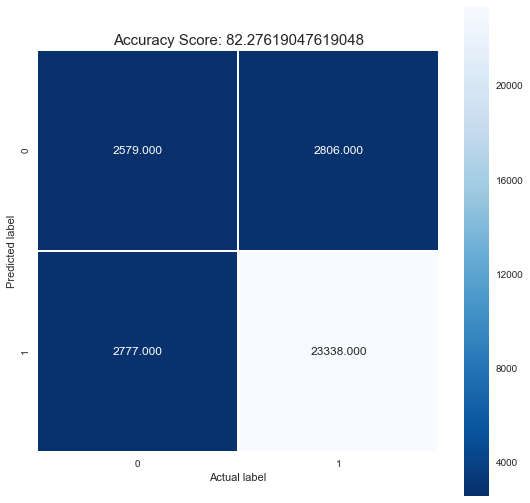


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     82.27619047619048     |
|       Classification_error      |     17.723809523809525    |
|          True positive          |           23338           |
|          False positive         |            2806           |
|          True negative          |            2579           |
|          False negative         |            2777           |
|        True positive rate       |     89.36626459888953     |
|       False negative rate       |     10.633735401110473    |
|        True negative rate       |     47.89229340761374     |
|       False positive rate       |     52.10770659238626     |
|         Precision value         |    

In [22]:
Confusion_metric(y_cv,Pred,Acc)

## Observations
<ul>
   <li>The train accuracy of the above model is 82.276% but is quite misleading which can be observed by analyzing the performance metrics of the confusion matrix.</li>
   <li>The False positive rate and the false negative rate is quite high which is not good for an classification model.</li>
   <li>The True negative rate is quite low which is very bad as the negative reviews are not properly classified and the model is facing a bias problem which can be improved after tuning the hyperparameters.</li>
    

### Tuning the Hyper-parameters by using 10k-fold Cross validation technique

--------------------------------------------------------------------------------------------------------
for depth = 2

the misclassification error for each depth value is :  [0.565]
--------------------------------------------------------------------------------------------------------
for depth = 3

the misclassification error for each depth value is :  [0.565 0.467]
--------------------------------------------------------------------------------------------------------
for depth = 4

the misclassification error for each depth value is :  [0.565 0.467 0.428]
--------------------------------------------------------------------------------------------------------
for depth = 5

the misclassification error for each depth value is :  [0.565 0.467 0.428 0.423]
--------------------------------------------------------------------------------------------------------
for depth = 6

the misclassification error for each depth value is :  [0.565 0.467 0.428 0.423 0.397]
-------------------------

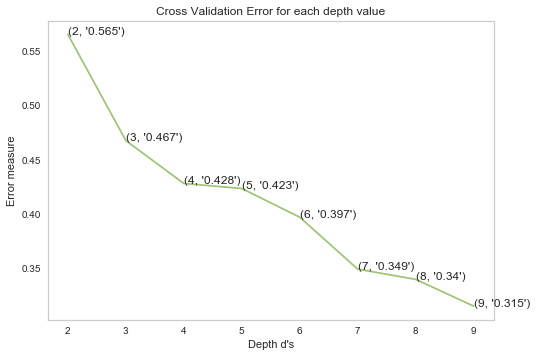


The optimal number of depth value is 9.


In [22]:

cv_results(X_tra,y_tr)

### Training the Decision tree classiffier model with optimal depth value

In [23]:
y_Pred,accur=tuned_test(X_tra,y_tr,X_tes,y_test,9)


The model score on train set is=  0.6937687074829932

The accuracy of Decision tree over test set is =  69% 


[[ 6265  1678]
 [11838 25219]]


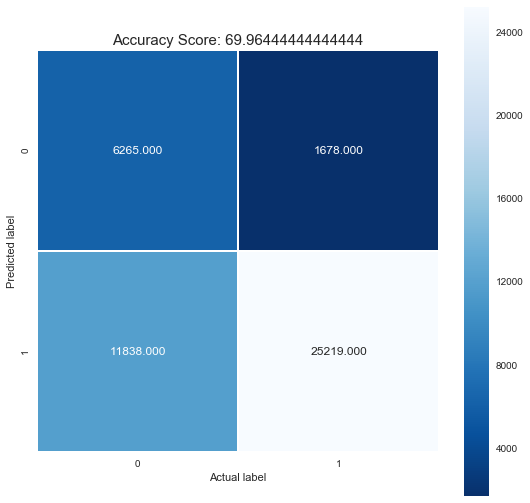


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     69.96444444444444     |
|       Classification_error      |     30.035555555555554    |
|          True positive          |           25219           |
|          False positive         |            1678           |
|          True negative          |            6265           |
|          False negative         |           11838           |
|        True positive rate       |     68.05461856059584     |
|       False negative rate       |     31.945381439404162    |
|        True negative rate       |     78.87448067480801     |
|       False positive rate       |     21.125519325191995    |
|         Precision value         |    

In [24]:
Confusion_metric(y_test,y_Pred,accur)

## Observations
<ul>
    <li>The test accuracy with optimal depth is 68.96% which is quite low for a classification model.</li>
    <li>This drop in accuracy is due to increase in the false negative rates and the False positive rates which is hampering the model's performance.</li>
    <li>But still the model is good and stable because of high True positive and negative rates as compared to the default model.</li>
    <li>The precision and the F1_scores values are good but the recall value is very low which is quite alarming.</li>
    <li>Since descion trees tends to overfitt as the depth increases so this might be reason for low accuracy because here after tuning the depth parameter the optimal value was 9.</li>
    <li>Let's see the performance of the model might increase after changing the vectorizers.</li>

## Implementing the Average word2vectorization technique

In [25]:
#code for finding the average word2vec

#Utility function for implementing the Average-word2vec-vectorization techniques

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors

def Average_word2Vec (X_tr,X_test):
    
# Train our own Word2Vec model using text corpus
    Train_sentence_list=[]
    for sentence in X_tr:
        Train_sentence_list.append(sentence.split())
    
    Test_sentence_list=[]
    for sentence in X_test:
        Test_sentence_list.append(sentence.split())
   
    print("length of train list set is as follows: ",len(Train_sentence_list))
    print("length of test list set is as follows : ",len(Test_sentence_list))
    print("*"*100)

# Generate model and train our model on train data
    w2v_model=w2v_model_train =gensim.models.Word2Vec(Train_sentence_list,min_count=5,size=50, workers=6)

    # List of word in vocabulary 
    w2v_words = list(w2v_model_train.wv.vocab)
    print("length of the W2v vocabulary is : ",len(w2v_words))

#Finding the average word2vec over the train set
    train_list = []
    for sentence in Train_sentence_list:
        word_2_vec = np.zeros(50)
        cnt_words = 0
        for word in sentence:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                word_2_vec += vec
                cnt_words += 1
        if cnt_words != 0 :
            word_2_vec /= cnt_words
        train_list.append(word_2_vec)
    
 #Finding the average word2vec over the test set    
    test_list = []
    for sentence in Test_sentence_list:
        word_2_vec = np.zeros(50)
        cnt_words = 0
        for word in sentence:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                word_2_vec += vec
                cnt_words += 1
        if cnt_words != 0 :
            word_2_vec /= cnt_words
        test_list.append(word_2_vec)
    
    
    print("The size of the trained average word2vec is :",len(train_list))
    print("The dimensions of average word2vec is :",len(train_list[0]))
    print()
    print("The size of the test average word2vec is :",len(test_list))
    print("The dimensions of the test average word2vec is :",len(test_list[0]))
    
    return Train_sentence_list,Test_sentence_list,w2v_model,w2v_words,train_list,test_list




### Preparing the Average word2vec data for further use 

In [26]:
Train=X_tr["CleanedText"]
Test=X_test["CleanedText"]

tr_list,tes_list,model,words,trw2v,testw2v=Average_word2Vec(Train,Test)

length of train list set is as follows:  73500
length of test list set is as follows :  45000
****************************************************************************************************
length of the W2v vocabulary is :  11158
The size of the trained average word2vec is : 73500
The dimensions of average word2vec is : 50

The size of the test average word2vec is : 45000
The dimensions of the test average word2vec is : 50


### Training the Decision Tree classiffier with default hyperparameters

In [28]:
%%time
w2v_pred,w2v_acc=train(trw2v,y_tr,testw2v,y_test)


The model score on train set is=  1.0

The accuracy of Decision tree over cross_val set is =  81% 
Wall time: 5.1 s


[[ 3313  4630]
 [ 3746 33311]]


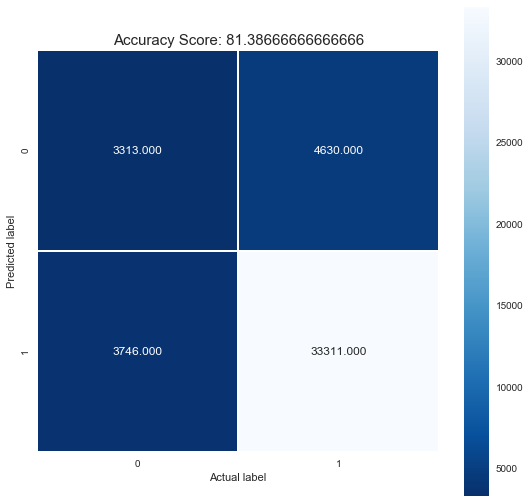


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     81.38666666666666     |
|       Classification_error      |     18.613333333333333    |
|          True positive          |           33311           |
|          False positive         |            4630           |
|          True negative          |            3313           |
|          False negative         |            3746           |
|        True positive rate       |     89.89124861699544     |
|       False negative rate       |     10.108751383004561    |
|        True negative rate       |     41.70968148054891     |
|       False positive rate       |     58.29031851945109     |
|         Precision value         |    

In [29]:
Confusion_metric(y_test,w2v_pred,w2v_acc)

## Observations
<ul>
   <li>The train accuracy of the above model is 81.36% but is quite misleading which can be observed by analyzing the performance metrics of the confusion matrix.</li>
   <li>The False positive rate and the false negative rate is quite high which is not good for an classification model.</li>
   <li>The True negative rate is quite low which is very bad as the negative reviews are not properly classified and the model is facing a bias problem which can be improved after tuning the hyperparameters.</li>
 

### Tuning the hyperparameters by using the 10k-fold cross validation technique

--------------------------------------------------------------------------------------------------------
for depth = 2

the misclassification error for each depth value is :  [0.422]
--------------------------------------------------------------------------------------------------------
for depth = 3

the misclassification error for each depth value is :  [0.422 0.265]
--------------------------------------------------------------------------------------------------------
for depth = 4

the misclassification error for each depth value is :  [0.422 0.265 0.289]
--------------------------------------------------------------------------------------------------------
for depth = 5

the misclassification error for each depth value is :  [0.422 0.265 0.289 0.29 ]
--------------------------------------------------------------------------------------------------------
for depth = 6

the misclassification error for each depth value is :  [0.422 0.265 0.289 0.29  0.269]
-------------------------

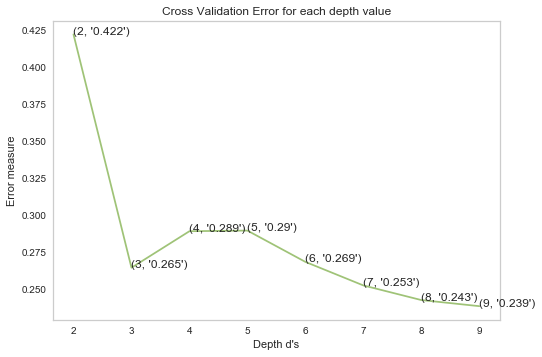


The optimal number of depth value is 9.


In [30]:
cv_results(trw2v,y_tr)

### Testing the model over the Test set by using the optimal depth value 

In [31]:
y_Predi,accura=tuned_test(trw2v,y_tr,testw2v,y_test,9)


The model score on train set is=  0.801795918367347

The accuracy of Decision tree over test set is =  74% 


### Confusion matrix of the above model is as follows   

[[ 5851  2092]
 [ 9581 27476]]


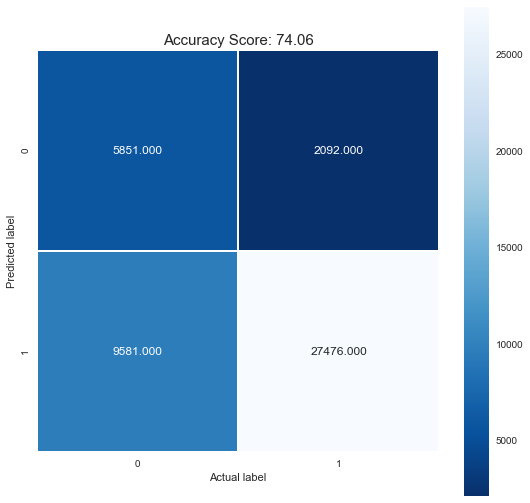


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |           74.06           |
|       Classification_error      |           25.94           |
|          True positive          |           27476           |
|          False positive         |            2092           |
|          True negative          |            5851           |
|          False negative         |            9581           |
|        True positive rate       |     74.14523571794803     |
|       False negative rate       |     25.854764282051974    |
|        True negative rate       |      73.6623442024424     |
|       False positive rate       |     26.337655797557595    |
|         Precision value         |    

In [32]:
Confusion_metric(y_test,y_Predi,accura)

### Observations
<ul>
    <li> The Test accuracy of the model is 74.06% which is low than default model but it is sensible as the diagonal element values are quite high as compared to other elements.</li>
    <li>The False positive and the negative rates are 25% and 26% which is considerable and the main reason of decreasing the accuracy so here the model is little overfitting.</li>
    <li>The model here is doing quite a good job in classiffying the model properly as compared to the previous vectorizers.
    <li>So by Observing the the confusion matrix and the performance of the above model I can conclude that the model is quite stable and sensible in classifying the reviews properly.</li>
    <li>So let's try the Tf-idf weighted word2vec vectorization technique and hope for the best results.</li>

## Implementing the Tf-IDF Weighted word2vec Vectorization technique  

In [33]:

def Tf_idf_vector( X_tr,train_list,test_list,model,words):
    
    Tfidf_vector=TfidfVectorizer()
    Tf_train=Tfidf_vector.fit_transform( X_tr)
    dictionary = dict(zip(Tfidf_vector.get_feature_names(), list(Tfidf_vector.idf_)))
   
    Train_sentence_list=train_list
    Test_sentence_list=test_list
    w2v_words=words
    w2v_model= model
    
    train_list_vector=[]
    row=0
    for sentence in  Train_sentence_list:
        word_2_vec=np.zeros(50)
        weight_tfidf_sum=0
        for word in sentence:
            if word in w2v_words:
                vec=w2v_model.wv[word]
            #tfidf_value=Tf_train[row,Dimension.index(word)]
                tf_idf = dictionary[word]*sentence.count(word)
                word_2_vec +=(vec *tf_idf)
                weight_tfidf_sum +=tf_idf
        if weight_tfidf_sum !=0:
            word_2_vec /=weight_tfidf_sum
        train_list_vector.append(word_2_vec)
        row +=1
    print(len(train_list_vector))
    print(len(train_list_vector[0]))

#Code for preapring the test_list_vector    
    TEST_LIST_VECTOR=[]
    Row=0
    for sentence in  Test_sentence_list:
        word_2_vec=np.zeros(50)
        weight_tf_sum=0
        for word in sentence:
            if word in w2v_words:
                vec=w2v_model.wv[word]
            #tfidf_value=Tf_test[Row,Dimension.index(word)]
                tf_idf = dictionary[word]*sentence.count(word)
                word_2_vec += (vec* tf_idf)
                weight_tf_sum += tf_idf
        if weight_tf_sum !=0:
            word_2_vec /=weight_tf_sum
        TEST_LIST_VECTOR.append(word_2_vec)
        row += 1
    print(len(TEST_LIST_VECTOR))
    print(len(TEST_LIST_VECTOR[0]))

    return train_list_vector,TEST_LIST_VECTOR



### Preparing the TF-IDF weighted vectorized data for the further implementations

In [35]:
Xtrain=X_tr["CleanedText"]

tfidf_tr,tfidf_test=Tf_idf_vector(Xtrain,tr_list,tes_list,model,words)

73500
50
45000
50


### Training the Decision tree classiffier model by using the default parameters

In [38]:
TF_pred,TF_acc=train(tfidf_tr,y_tr,tfidf_test,y_test)


The model score on train set is=  1.0

The accuracy of Decision tree over cross_val set is =  79% 


### Confusion matrix of the above model is as follows

[[ 2905  5038]
 [ 4148 32909]]


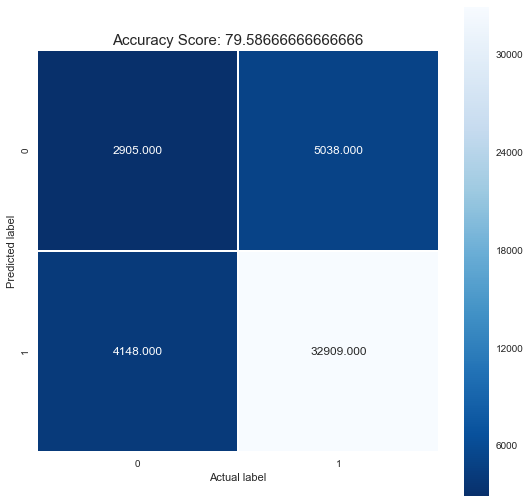


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     79.58666666666666     |
|       Classification_error      |     20.413333333333334    |
|          True positive          |           32909           |
|          False positive         |            5038           |
|          True negative          |            2905           |
|          False negative         |            4148           |
|        True positive rate       |     88.80643333243383     |
|       False negative rate       |     11.193566667566182    |
|        True negative rate       |     36.57308321792774     |
|       False positive rate       |     63.42691678207226     |
|         Precision value         |    

In [39]:
Confusion_metric(y_test,TF_pred,TF_acc) 

### Tuning the hyperaprameters by using 10k-fold Cross-validation technique

--------------------------------------------------------------------------------------------------------
for depth = 2

the misclassification error for each depth value is :  [0.42]
--------------------------------------------------------------------------------------------------------
for depth = 3

the misclassification error for each depth value is :  [0.42  0.298]
--------------------------------------------------------------------------------------------------------
for depth = 4

the misclassification error for each depth value is :  [0.42  0.298 0.28 ]
--------------------------------------------------------------------------------------------------------
for depth = 5

the misclassification error for each depth value is :  [0.42  0.298 0.28  0.289]
--------------------------------------------------------------------------------------------------------
for depth = 6

the misclassification error for each depth value is :  [0.42  0.298 0.28  0.289 0.294]
--------------------------

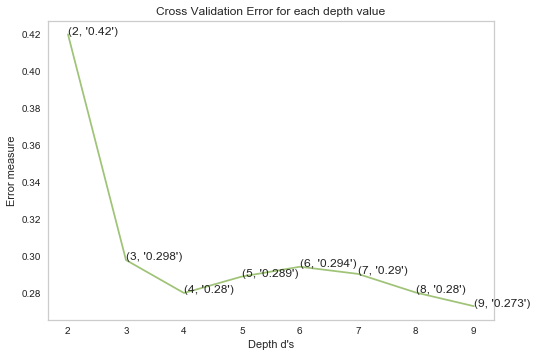


The optimal number of depth value is 9.


In [40]:
cv_results(tfidf_tr,y_tr)

### Testing the Decision tree model with optimal hyperparmeters

In [41]:
tfy_Predi,tfaccura=tuned_test(tfidf_tr,y_tr,tfidf_test,y_test,9)


The model score on train set is=  0.7780136054421769

The accuracy of Decision tree over test set is =  72% 


### Confusion matrix of the model 

[[ 5580  2363]
 [10136 26921]]


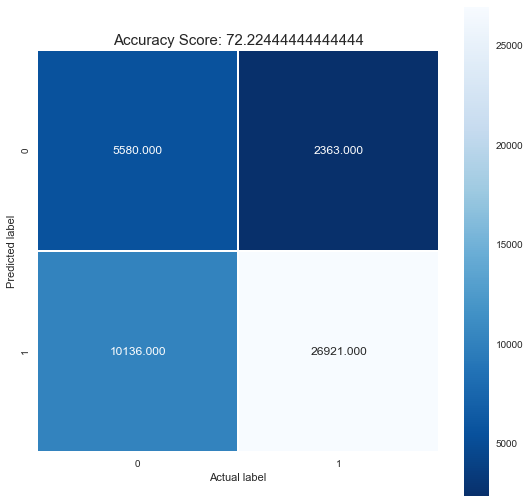


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     72.22444444444444     |
|       Classification_error      |     27.775555555555552    |
|          True positive          |           26921           |
|          False positive         |            2363           |
|          True negative          |            5580           |
|          False negative         |           10136           |
|        True positive rate       |     72.64754297433683     |
|       False negative rate       |     27.352457025663167    |
|        True negative rate       |     70.25053506231902     |
|       False positive rate       |     29.749464937680976    |
|         Precision value         |    

In [42]:
Confusion_metric(y_test,tfy_Predi,tfaccura) 

### Observations
<ul>
    <li> The Test accuracy of the model is 72.22% which is low than previous Avg-w2v-model but it is sensible as the diagonal element values are quite high as compared to other elements.</li>
    <li>The False positive and the negative rates are 29% and 27% which is considerable and the main reason of decreasing the accuracy so here the model is little overfitting.</li>
    <li>The model here is doing quite a good job in classiffying the model properly as compared to the previous vectorizers.
    <li>So by Observing the the confusion matrix and the performance of the above model I can conclude that the model is quite stable and sensible in classifying the reviews properly.</li>
    

# <center>Conclusion</center>
___

In [52]:
conclusion_table()


+-------------------------------------------------------------------------------------+
|               The comparisons of all the vectorizers are as follows:                |
+--------------------------+---------------------------+-------------------+----------+
|        Vectorizer        |         Algorithm         |       Scores      |  Status  |
+--------------------------+---------------------------+-------------------+----------+
|       Bag-Of-Words       | Decision-Tree-Classiffier | 73.41777777777779 | Overfitt |
|          Tf-IDF          | Decision-Tree-Classiffier | 69.96444444444444 | Overfitt |
|     Average-word2vec     | Decision-Tree-Classiffier |       74.06       | Overfitt |
| TF-IDF-Weighted-word2vec | Decision-Tree-Classiffier | 72.22444444444444 | Overfitt |
+--------------------------+---------------------------+-------------------+----------+


<ul>
    <li>From the above comparison table I can conclude that Decision tree Classiffier easily overfitts in text data because of increased depth value even after tuning the hyperparameters.</li>
    <li>The Average word2vec vectorizer gave the best accuracy as compared to the other vectorizers.</li>
    <li>Decsion tree classiffier is not the goto model if the data is text or a high dimensional data.</li>
    